In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('Nivel_Procesado_1904-2023.csv')
df2 = pd.read_csv('Nivel_Caudal_Asu_Con_1960_2024.csv')

In [3]:
df1.info() # Información del dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43545 entries, 0 to 43544
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     43545 non-null  object 
 1   valor009  2640 non-null   float64
 2   valor010  19359 non-null  float64
 3   valor033  33439 non-null  float64
 4   valor088  18802 non-null  float64
 5   valor134  41430 non-null  float64
 6   valor183  33292 non-null  float64
 7   valor184  1177 non-null   float64
 8   valor191  196 non-null    float64
 9   valor210  2357 non-null   float64
 10  valor211  33249 non-null  float64
 11  e218      43512 non-null  float64
 12  valor219  1237 non-null   float64
 13  valor248  2459 non-null   float64
 14  valor252  1278 non-null   float64
 15  valor253  1286 non-null   float64
 16  valor254  12654 non-null  float64
 17  valor255  33287 non-null  float64
 18  valor257  2401 non-null   float64
 19  valor258  1105 non-null   float64
 20  valor261  10386 non-null  fl

In [9]:
df1.isnull().sum() #Contidad de valores nulos en cada columna

fecha           0
valor009    40905
valor010    24186
valor033    10106
valor088    24743
valor134     2115
valor183    10253
valor184    42368
valor191    43349
valor210    41188
valor211    10296
e218           33
valor219    42308
valor248    41086
valor252    42267
valor253    42259
valor254    30891
valor255    10258
valor257    41144
valor258    42440
valor261    33159
valor263    42337
valor264    42189
valor288    41350
valor295    42443
valor297    41169
dtype: int64

In [17]:
df1_copy = df1.copy() # Realiza una copia del dataframe original
df1_copy['fecha'] = pd.to_datetime(df1_copy['fecha']) # Conversión de la columna fecha a datetime
df1_copy.set_index('fecha', inplace = True) # Coloca fecha como indice
datos_asu = df1_copy['e218'] # Toma los datos de niveles de asunción
datos_asu = datos_asu.interpolate(limit = 35, method = 'quadratic', limit_direction = 'both') # Interpolación de los datos faltantes de asunción 
dataset1 = pd.DataFrame(datos_asu) # Crea un dataset con los datos de asunción procesados
dataset1.columns = ['nivel'] # Nombra la columna del dataset como 'nivel'

In [18]:
filtered_data1 = dataset1.loc['1960-01-01':]

In [19]:
df2_copy = df2.copy() # Realiza una copia del dataframe original
df2_copy['fecha'] = pd.to_datetime(df2_copy['fecha']) # Conversión de la columna fecha a datetime
df2_copy.set_index('fecha', inplace = True) # Coloca fecha como indice
datos_asu = df2_copy['Qcon'] # Toma los datos de niveles de asunción
datos_asu = datos_asu.interpolate(limit = 35, method = 'quadratic', limit_direction = 'both') # Interpolación de los datos faltantes de asunción 
dataset2 = pd.DataFrame(datos_asu) # Crea un dataset con los datos de asunción procesados
dataset2.columns= ['caudal_con'] # Nombra la columna del dataset como 'nivel'

In [20]:
filtered_data2 = dataset2.loc[:'2023-03-21']

In [21]:
df_new = dataset1.join(dataset2, how='inner')

In [22]:
datos_norm = df_new.copy() # Copia del dataframe 

datos_norm['week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53) # Añade una columna normalizada de acuerdo a 53 semanas (53 semanas equivale a 1 estación)
datos_norm['week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53) # Añade una columna normalizada de acuerdo a 53 semanas (53 semanas equivale a 1 estación)
horizonte = 28 # Cantidad de días a predecir
tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
cantidad_unidades = 30 # Cantidad de neuronas
tamanio_batch = 30 # Tamaño del batch
dropout = 0.25 # Probabilidad para desactivar una neurona
features_set = 1 # Posición de características para el entrenamiento
year_ini = 73 # Año inicial
arch = 'LSTM' # Arquictura del modelo
modelo = arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)+'_d'+str(dropout)+'_f'+str(features_set)+'_y'+str(year_ini)

In [23]:
datos_norm

,nivel,caudal_con,week_cos,week_sin
fecha,,,,
1960-01-01,5.20,1914.5,1.0,-0.0
1960-01-02,5.16,1869.8,1.0,-0.0
1960-01-03,5.09,1824.6,1.0,-0.0
1960-01-04,5.02,1778.8,0.992981,0.118273
1960-01-05,4.92,1741.9,0.992981,0.118273
...,...,...,...,...
2023-03-17,4.97,3182.3,0.263587,0.964636
2023-03-18,5.07,3159.2,0.263587,0.964636
2023-03-19,5.15,3133.0,0.263587,0.964636


In [24]:
def preparar_datos(tamanio_ventana,horizonte, data): # Función para la división datos para el entrenamiento
    n_features=len(data.columns)
    x_train = np.zeros((len(data)-tamanio_ventana-horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros((len(data)-tamanio_ventana-horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1):
        x_train[(i-tamanio_ventana), :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[i-tamanio_ventana, :] = data['nivel'].iloc[(i):(i+horizonte)]
    return x_train,y_train

In [25]:
import tensorflow as tf
import datetime as dt
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
tf.config.experimental.enable_op_determinism()

In [26]:
lista = [['nivel'],['nivel','caudal_con','week_cos','week_sin']] # Lista con 2 columnas
seed = 42 # Valor elegida para la semilla
tf.random.set_seed(seed) # Establece la semilla para los generadores de números aletorios de TensorFlow
np.random.seed(seed) # Establece la semilla para los generadores de números aleatorios de NumPy
datos_normm = datos_norm[lista[features_set]].copy()
nfeatures = len(datos_normm.columns) # Cantidad de features

In [27]:
nfeatures

4

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año 'year_ini' hasta 'tamanio_ventana' días antes 
train = datos_normm.loc[desde:'2004-01-01'] # Selección para el conjunto de datos para el entrenamiento 
ix = train.index # Toma los indices del conjunto de datos de entrenamiento
trainScaler = MinMaxScaler(feature_range = (0, 1)) # Inicializa una normalización de 0 a 1 para el conjunto de datos de entrenamiento
trainScaler.fit(train) # Ajusta la normalización a los datos de entrenamiento
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns) # Crea un dataframe con el conjunto de datos de entrenamiento normalizados y ajustados
trainScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_train, y_train = preparar_datos(tamanio_ventana,horizonte, trainScaled) # Divide los datos de entrenamiento

In [35]:
trainScaled.set_index(ix, inplace = True) 

In [36]:
trainScaled

,nivel,caudal_con,week_cos,week_sin
fecha,,,,
1972-01-02,0.031285,0.069468,0.996487,0.440837
1972-01-03,0.024581,0.069468,0.996487,0.559163
1972-01-04,0.022346,0.069468,0.996487,0.559163
1972-01-05,0.021229,0.067521,0.996487,0.559163
1972-01-06,0.020112,0.065574,0.996487,0.559163
...,...,...,...,...
2003-12-28,0.524022,0.429117,0.996487,0.440837
2003-12-29,0.525140,0.418170,0.996487,0.559163
2003-12-30,0.521788,0.400757,0.996487,0.559163


In [37]:
desde = (dt.datetime.strptime('2005-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2014-01-01' hasta 'tamanio_ventana' días antes
val = datos_normm.loc[desde:'2012-01-01'] # Toma el conjunto de datos para la validación 
ix = val.index # Toma los indices del conjunto de datos de validación
valScaler = MinMaxScaler(feature_range=(0, 1)) # Inicializa una normalización de 0 a 1 para el conjunto de datos de validación
valScaler.fit(val) # Ajusta la normalización a los datos de validación
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns) # Crea un dataframe con el conjunto de datos de validación normalizados y ajustados
valScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_val, y_val = preparar_datos(tamanio_ventana,horizonte, valScaled) # Divide los datos de validación

In [258]:
## Hacer los graficos para los ver los datos
trainScaled.loc['2004-01-01']

nivel       0.512849
week_cos    0.996487
week_sin    0.559163
Name: 2004-01-01 00:00:00, dtype: float64

In [38]:
from statsmodels.tsa.stattools import adfuller #Importa la función 'adfuller' de la biblioteca 'statsmodels' para realizar la prueba de Dickey-Fuller aumentada (ADF) a la serie temporal 

In [39]:
X = train['nivel'].values # Convierte la columna 'nivel' del dataframe en un array de NumPy
result = adfuller(X) # Ejecuta la prueba ADF sobre los datos de nivel (herramienta estadística utilizada para determinar si una serie temporal es estacionaria o no)
print('ADF Statistic: %f' % result[0]) # Muestra el estadístico ADF (Este estadístico se compara con los valores críticos para determinar la estacionariedad de la serie temporal)
print('p-value: %f' % result[1]) # Muestra el valor p (se utiliza para determinar si se puede rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria (es decir, no es estacionaria))
print('Critical Values:') #Muestra los valores críticos 
for key, value in result[4].items(): # Es un diccionario que contiene los valores críticos para diferentes niveles de confianza (por ejemplo, 1%, 5%, 10%). Estos valores se utilizan para comparar con el estadístico ADF.
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.380309
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [41]:
model = tf.keras.Sequential() # Defición de la arquitectura RNN (Red Neuronal Recurrente)
model.add(tf.keras.layers.LSTM(cantidad_unidades, input_shape=(tamanio_ventana, nfeatures))) # Añade una capa LSTM (Long Short-Term Memory) al modelo (adecuadas para modelar datos secuenciales y capturar dependencias a lorgo plazo)
model.add(tf.keras.layers.Dropout(rate=dropout)) # Añade una capa de regularización Dropout para prevenir el sobreajuste durante el entrenamiento
model.add(tf.keras.layers.Dense(horizonte)) # Añade una capa densa. Las capas densa conectan cada neurona de la capa anterior con cada neurona de la capa siguiente. 'horizonte' especifica el número de unidas en la capa de salida, en el contexto es el número de días en el futuro que se desea predecir

2024-06-06 01:29:12.484663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4719 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:03:00.0, compute capability: 7.5


In [42]:
def exponential_decay_weights(seq_length, decay_factor): #seq_legth dimension de la secuencia temporal , decay factor tasa de disminucion de peso
    weights = np.exp(-decay_factor * np.arange(seq_length))#cada elemento del vector  se calcula con el exp(-factor* ...)
    return weights / np.sum(weights) #retorna un vector weights de long seq_length np.sum suma el total de los pesos y normaliza para que el total sea 1

In [43]:
# Esta función calcula el error cuadrático medio (MSE)
# ponderado a lo largo de la secuencia temporal, teniendo en cuenta la importancia decreciente de los elementos anteriores.
def multi_step_loss(y_true, y_pred): #tensores y_true , y_pred donde y_true (etiquetas) , y_pred valores predichos del modelo
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 28  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)#usamos la funcion anterior para los pesos
    squared_diff = tf.square(y_true - y_pred)#diferencia al cuadrado elemento a elemento entre (y_true - y_pred)
    weighted_squared_diff = tf.math.multiply(squared_diff, tf.expand_dims(weights, axis=-1))
    mse= tf.reduce_mean(weighted_squared_diff )#error cuadratico medio ponderado
    num_steps = 28  # Number of steps in each prediction
    adjusted_loss = mse / num_steps #ajuste de acuerdo al nro de pasos
    return adjusted_loss #error cuadratico medio

In [44]:
from tensorflow.keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()]) # Especifica el optimizador, la función de pérdida y las métricas que se usarán para evaluar el modelo.
model.summary() # Muestra la descripción del modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                4200      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 28)                868       
                                                                 
Total params: 5068 (19.80 KB)
Trainable params: 5068 (19.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
import time

In [47]:
start_time = time.time() # Registra el tiempo inicial en segundos desde la época
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # Permite detener el enetrenamiento del modelo cuando una métrica monitoreada no mejora después de un número determinado de épocas
initial_learning_rate = 0.0005 # Tasa de aprendizaje inicial
def lr_step_decay(epoch, lr): # Definición de decaimiento de la tasa de aprendizaje 
    drop = 0.5 # Factor por el cual se reduce la tasa de aprendizaje
    epochs_drop = 10 # Número de épocas después de las cules se reduce la tasa de aprendizaje
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # Renueva la tasa de aprendizaje calculada
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay) # Crea el callback que ajustará la tasa de aprendizaje según la función definida
epocas = 250 # Número de épocas
callbacks_list = [early_stopping,lr_scheduler ] # Lista de callbacks que serán usadas para el entrenamiento
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list) # Entrenamiento del modelo con los callbaaks

2024-06-06 01:29:36.953884: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65968640 exceeds 10% of free system memory.
2024-06-06 01:29:38.396002: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65968640 exceeds 10% of free system memory.
2024-06-06 01:29:38.467370: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65968640 exceeds 10% of free system memory.


Epoch 1/250


2024-06-06 01:29:44.422330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-06-06 01:29:46.430519: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe5cc043890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 01:29:46.450698: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-06-06 01:29:47.399061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 01:29:50.396169: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-06 01:29:51.360966: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 [==============================] - 27s 28ms/step - loss: 7.1336e-05 - root_mean_squared_error: 0.2365 - val_loss: 6.0356e-05 - val_root_mean_squared_error: 0.2175 - lr: 5.0000e-04
Epoch 2/250
377/377 [==============================] - 7s 19ms/step - loss: 2.1090e-05 - root_mean_squared_error: 0.1286 - val_loss: 4.2142e-05 - val_root_mean_squared_error: 0.1818 - lr: 5.0000e-04
Epoch 3/250
377/377 [==============================] - 7s 18ms/step - loss: 1.4602e-05 - root_mean_squared_error: 0.1070 - val_loss: 3.4951e-05 - val_root_mean_squared_error: 0.1655 - lr: 5.0000e-04
Epoch 4/250
377/377 [==============================] - 8s 20ms/step - loss: 1.1550e-05 - root_mean_squared_error: 0.0952 - val_loss: 3.0118e-05 - val_root_mean_squared_error: 0.1537 - lr: 5.0000e-04
Epoch 5/250
377/377 [==============================] - 8s 20ms/step - loss: 9.5927e-06 - root_mean_squared_error: 0.0867 - val_loss: 2.7517e-05 - val_root_mean_squared_error: 0.1469 - lr: 5.0000e-04
Epoch 6/250
377/

In [48]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error

In [49]:
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0] # Predicción del modelo sobre los datos de validación, y luego aplica una transformación inversa para delver los datos a su escala original
y_val_inv = valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0] # Transformación inversa de 'y_val' a su escala original
mse = mean_squared_error( y_val_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_val_inv, Y_prediction) # Error máximo entre y_val_inv e y y_prediction
r2_ = r2_score(y_val_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de validación. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_val_inv - Y_prediction) ** 2) / np.sum((y_val_inv - np.mean(y_val_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

80/80 [==============================] - 2s 7ms/step
MSE: 0.20209311636144933 RMSE:0.4495476797420373
MaxError: 2.7342951181530957 R2:0.8103755410466746
NSE: 0.8103755410466746
Time step : 660.463744 seconds


In [53]:
import seaborn as sns

In [54]:

from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates 
from matplotlib import dates as mdates
import matplotlib.pyplot as plt

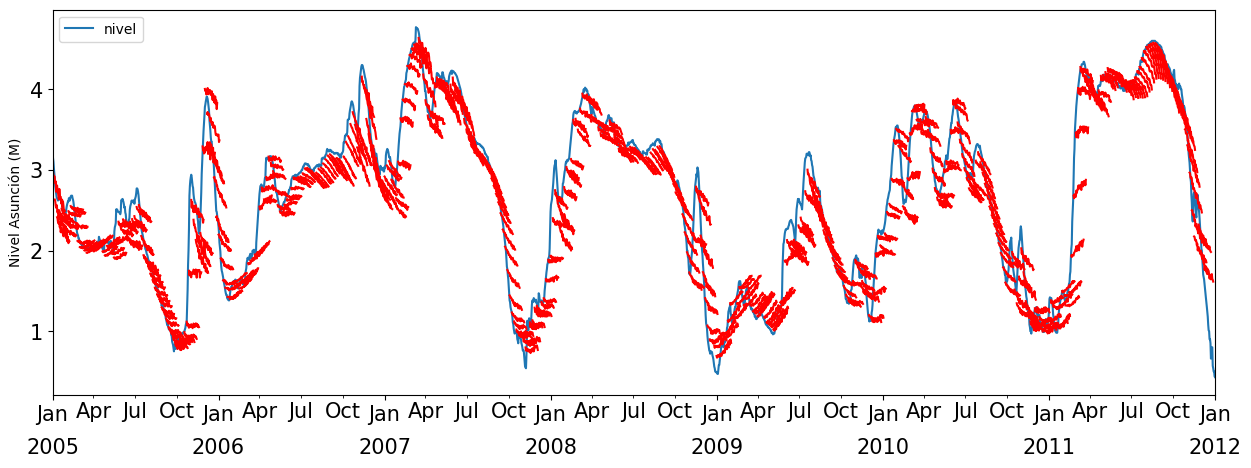

In [55]:
df = val[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()

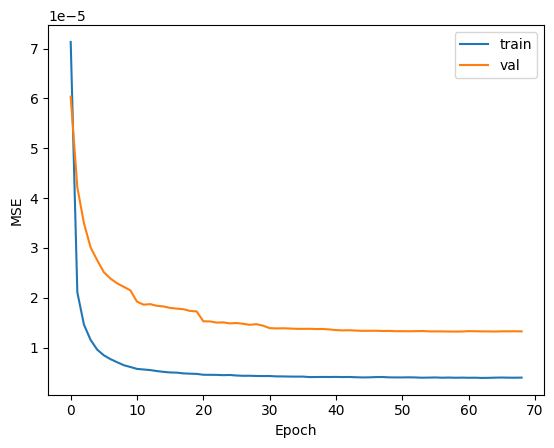

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [57]:
desde = (dt.datetime.strptime('2013-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2018-01-01' hasta 'tamanio_ventana' días antes
test = datos_normm.loc[desde:'2022-01-01'] # Toma el conjunto de datos para la test
ix = test.index # Toma los indices del conjunto de datos de test
testScaler = MinMaxScaler(feature_range=(0, 1)) # Inicializa una normalización de 0 a 1 para el conjunto de datos de test
testScaler.fit(test) # Ajusta la normalización a los datos de test
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns) # Crea un dataframe con el conjunto de datos de test normalizados y ajustados
testScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_test, y_test = preparar_datos(tamanio_ventana,horizonte, testScaled) # Divide los datos de test

In [58]:
Y_prediction = testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Predicción del modelo sobre los datos de test, y luego aplica una transformación inversa para delver los datos a su escala original
y_test_inv = testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Transformación inversa de 'y_test' a su escala original
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_test_inv, Y_prediction) # Error máximo entre y_test_inv e y y_prediction
r2_ = r2_score(y_test_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de test. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_test_inv - Y_prediction) ** 2) / np.sum((y_test_inv - np.mean(y_test_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

102/102 [==============================] - 4s 11ms/step
MSE: 0.45160922353080535 RMSE:0.6720187672459791
MaxError: 4.395392390787602 R2:0.8893116607921328
NSE: 0.8893116607921328
Time step : 815.598925 seconds


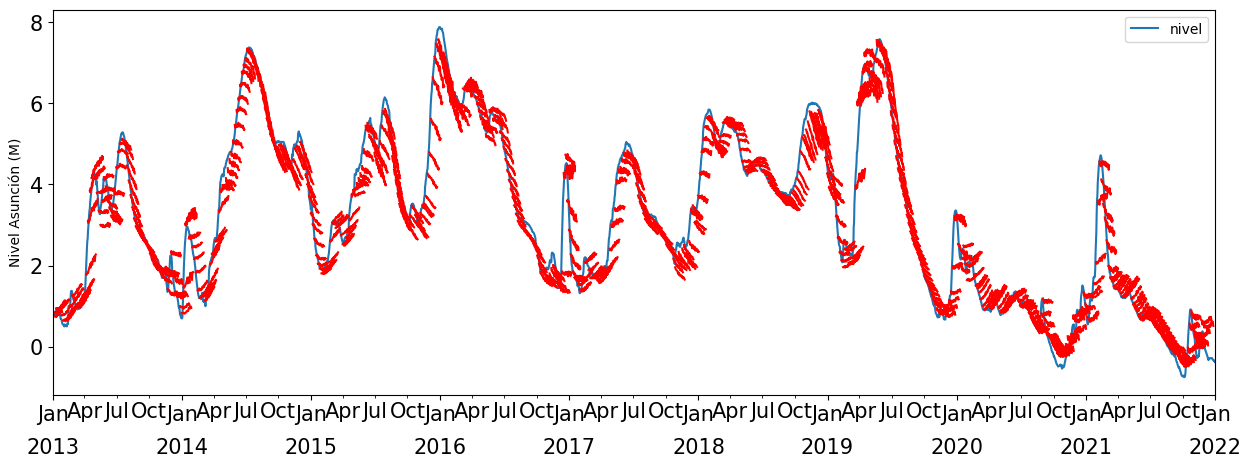

In [60]:
df = test[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()

In [231]:
print(modelo)

LSTM_h28_w365_u30_d0.25_f1_y73
